In [2]:
!pip install -r ../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [205]:
import pandas as pd
import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt 
from typing import Literal
import math
import warnings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

# Load Bond Returns data and Zero Rate Curve

## Bond Returns + Data Cleaning

For the definitions of the features, refer to the pdf in the `docs` folder

Variable Summary: 

* `cs`: credit spread computed as bond_yield in excess of duration-matched portfolio of US Treasuries yields
* `tmt`: time to maturity (in months, I guess)
* `ind_num_17`: Fama-French 17 Industry Classification (may be useful for value factor)
* `size_ig`, `size_jk`: dummy for (respectively) IG/HY bonds in the BAML/ICE index
* `bond_type`: US Corporate Convertible (CCOV), US Corporate Debentures (CDEB), US Corporate Medium Term Note (CMTN), US Corporate Medium Term Note Zero (CMTZ), or US Corporate Paper (CP)
* `R_FR`, `N_FR` and co.: rating as names and one-hot encoded, probably from different providers (SP may be S&P, FR Fitch Ratings, MR Moody's
* `INTEREST_FREQUENCY`: e.g. 13 for variable coupon, -1 for NA, 14 for bi-monthly, 15-16 undocumented
* `DATED_DATE`: date from which the bond interest accrues
* Additional Info on variables: FISD data dictionary 2012 document

Prices Variables

* `PRICE_EOM`: considers all trading days and takes the last
* `PRICE_LDM`: consider only last trading day of the month otherwise NaN
* `PRICE_L5M`: consider only last 5 trading days of the month otherwise NaN
* `T_SPREAD`: average trade-weighted bid-ask spread
* `T_YLD_PT`: average trade-weighted yield point
* `T_VOLUME`: volume traded during the month, par-value
* `T_DVOLUME`: volume traded during the month, dollar value
* `bondprc` is adjusted for MMN, `BONDPRC` is unadjusted

Other notes

* We may want to remove defaulted bonds (check if they were actually already removed)

In [4]:
date_cols = [
    'date', 
    'MATURITY',
    'OFFERING_DATE', 
    'FIRST_INTEREST_DATE', 
    'LAST_INTEREST_DATE',
    'nextcoup',
    'DEFAULT_DATE',
    'REINSTATED_DATE',
    'DATED_DATE'
]

bond_data = pd.read_csv('../data/bond_data_final.csv', index_col=0, parse_dates=date_cols)

bond_data.head(2)

C:\Users\andre\AppData\Local\Temp\ipykernel_36568\2964468240.py:13: DtypeWarning: Columns (98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  bond_data = pd.read_csv('../data/bond_data_final.csv', index_col=0, parse_dates=date_cols)


,date,cusip,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,...,RET_LDM,RET_L5M,TMT,REMCOUPS,DURATION_y,DEFAULTED,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE
0,2002-08-31,000336AE7,-0.056089,-0.087082,-0.081158,-0.054689,-0.008212,-0.009612,-0.023343,8.0,...,NaN,-.8212%,5.84,12.0,4.59,N,NaT,NaN,NaN,NaT
1,2002-09-30,000336AE7,0.050663,0.057193,0.054383,0.052063,-0.054689,-0.056089,-0.081158,8.0,...,-5.469%,-5.469%,5.75,12.0,4.44,N,NaT,NaN,NaN,NaT


In [5]:
# merge duration across the two dataframes
bond_data['duration'] = bond_data['DURATION_y'].fillna(bond_data['DURATION_x'])
bond_data.drop(['DURATION_x', 'DURATION_y'], axis=1, inplace=True)

In [8]:
useless_cols = [
    'company_symbol', # we do not need it
    'TREASURY_MATURITY', # we do not need it
    'CONV', # convertible bonds (we already removed all convertibles) 
    'sic_code', # SIC Industry Code (we don't need it) 
    'mom6_1', # 6m momentum (we don't need it) 
    'ltrev48_12', # sum of bond returns over 48months (momentum) 
    'TMT', # time to maturity in years (we have it in months in tmt) and TMT has NaNs while tmt does not
    'DATE', # has NaNs while date does not
    'CUSIP', # has Nans while cusip does not
    'COUPON', # repeated in coupon and COUPON has NaNs while coupon does not
]

bond_data.drop(useless_cols, axis=1, inplace=True, errors='ignore')

In [9]:
# fill all DATED_DATE, OFFERING_DATE, MATURITY, and DAY_COUNT_BASIS since they are all the same for each issue
cols_to_fill = ['DATED_DATE', 'OFFERING_DATE', 'DAY_COUNT_BASIS', 'MATURITY', 'NCOUPS']
grouped = bond_data.groupby('cusip')
def fill_dates(group): 
    group[cols_to_fill] = group[cols_to_fill].ffill().bfill()
    return group 

filled_data = grouped.apply(fill_dates, include_groups=False)
bond_data = filled_data.reset_index(0)

C:\Users\andre\AppData\Local\Temp\ipykernel_36568\3909775605.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group[cols_to_fill] = group[cols_to_fill].ffill().bfill()
C:\Users\andre\AppData\Local\Temp\ipykernel_36568\3909775605.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group[cols_to_fill] = group[cols_to_fill].ffill().bfill()
C:\Users\andre\AppData\Local\Temp\ipykernel_36568\3909775605.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(

In [10]:
# remove the CUSIPS for which there is no DATED_DATE, OFFERING_DATE and DAY COUNT BASIS? we should probably do that
new_bond_data = bond_data.dropna(subset=cols_to_fill)

removed_cusips = bond_data['cusip'].nunique() - new_bond_data['cusip'].nunique()
bond_data = new_bond_data

print(f'Removed {removed_cusips} CUSIPs from the DataFrame')

Removed 6 CUSIPs from the DataFrame


In [11]:
required_cols = ['coupon', 'date'] + cols_to_fill

bond_data[required_cols].isna().sum()

coupon             0
date               0
DATED_DATE         0
OFFERING_DATE      0
DAY_COUNT_BASIS    0
MATURITY           0
NCOUPS             0
dtype: int64

Great, now we have all variables needed for the analysis!

# Load the historical zero curve

In [48]:
yield_curve = pd.read_csv('../data/yield_panel_monthly_frequency_daily_maturity.csv', index_col=0)
yield_curve.index = pd.to_datetime(yield_curve.index)
yield_curve.drop('MAX_DATA_TTM', axis=1, inplace=True)  

In [49]:
yield_curve.dtypes

1        float64
2        float64
3        float64
4        float64
5        float64
          ...   
10946    float64
10947    float64
10948    float64
10949    float64
10950    float64
Length: 10950, dtype: object

In [67]:
yield_curve = yield_curve.resample('ME').last()


In [68]:
yield_curve.iloc[:10, :10]

,1,2,3,4,5,6,7,8,9,10
1961-06-30,0.022809,0.022810,0.022811,0.022813,0.022814,0.022816,0.022817,0.022819,0.022821,0.022823
1961-07-31,0.020838,0.020839,0.020840,0.020841,0.020843,0.020845,0.020847,0.020849,0.020851,0.020854
1961-08-31,0.021072,0.021074,0.021075,0.021077,0.021080,0.021083,0.021086,0.021089,0.021093,0.021098
1961-09-30,0.021769,0.021770,0.021772,0.021774,0.021776,0.021779,0.021782,0.021785,0.021789,0.021793
1961-10-31,0.022248,0.022249,0.022250,0.022252,0.022254,0.022256,0.022259,0.022261,0.022265,0.022268
1961-11-30,0.024908,0.024909,0.024910,0.024912,0.024914,0.024915,0.024918,0.024920,0.024922,0.024925
1961-12-31,0.026685,0.026687,0.026688,0.026690,0.026692,0.026694,0.026696,0.026699,0.026701,0.026704
1962-01-31,0.026356,0.026357,0.026359,0.026360,0.026362,0.026364,0.026366,0.026369,0.026372,0.026375
1962-02-28,0.026842,0.026843,0.026845,0.026846,0.026848,0.026850,0.026852,0.026854,0.026857,0.026859
1962-03-31,0.027758,0.027759,0.027760,0.027762,0.027763,0.027764,0.027766,0.027767,0.027769,0.027770


# OAS Calculation with QuantLib

OAS is the spread that added to the zero rates in the pricing function returns the price of the bond. We use the Newton method to get a solution for the OAS. In our case, since we stripped bonds with optionality, the OAS is the Z-Spread

In [15]:
bond_data['bondprc'].isna().sum() / bond_data.shape[0]

0.15038855769051246

In [92]:
mask_bond = (bond_data['cusip'] == '000336AE7') &(bond_data['date'] == '2002-08-31') 
example_bond = bond_data.loc[mask_bond].iloc[0] 

example_bond[:5]

cusip                        000336AE7
date               2002-08-31 00:00:00
exretn_t+1                   -0.056089
exretnc_t+1                  -0.087082
exretnc_dur_t+1              -0.081158
Name: 0, dtype: object

In [200]:
example_bond.MATURITY

Timestamp('2008-06-01 00:00:00')

In [118]:
bond_data.columns

Index(['cusip', 'date', 'exretn_t+1', 'exretnc_t+1', 'exretnc_dur_t+1',
       'bond_ret_t+1', 'bond_ret', 'exretn', 'exretnc_dur', 'rating', 'cs',
       'cs_6m_delta', 'bond_yield', 'bond_amount_out', 'offering_amt',
       'bondprc', 'perc_par', 'tmt', 'duration', 'ind_num_17', 'BOND_RET',
       'ILLIQ', 'var95', 'n_trades_month', 'size_ig', 'size_jk', 'BOND_YIELD',
       'CS', 'BONDPRC', 'PRFULL', 'CONVEXITY', 'CS_6M_DELTA', 'bond_value',
       'BOND_VALUE', 'coupon', 'bond_type', 'principal_amt', 'bondpar_mil',
       'ISSUE_ID', 'bond_sym_id', 'bsym', 'ISIN', 'BOND_TYPE',
       'SECURITY_LEVEL', 'OFFERING_DATE', 'OFFERING_AMT', 'OFFERING_PRICE',
       'PRINCIPAL_AMT', 'MATURITY', 'DAY_COUNT_BASIS', 'DATED_DATE',
       'FIRST_INTEREST_DATE', 'LAST_INTEREST_DATE', 'NCOUPS',
       'AMOUNT_OUTSTANDING', 'R_SP', 'R_MR', 'R_FR', 'N_SP', 'N_MR', 'N_FR',
       'RATING_NUM', 'RATING_CAT', 'RATING_CLASS', 'T_DATE', 'T_Volume',
       'T_DVolume', 'T_Spread', 'T_Yld_Pt', 'YIELD', 'P

In [108]:
def decompose_date(date: pd.Timestamp):
    """
    Returns day, month, year given a `pd.Timestamp`
    Parameters
    ----------
    date: pd.Timestamp

    Returns
    -------
    tuple[int, int, int]: day, month, year

    """
    return date.day, date.month, date.year

def get_day_count(bond: pd.Series): 
    day_count_convention = bond.DAY_COUNT_BASIS
    
    if day_count_convention == '30/360': 
        return ql.Thirty360(ql.Thirty360.USA)
    
    raise Exception(f'we did not implement day count {day_count_convention}')
    
def get_coupon_freq(bond: pd.Series): 
    coupon_freq = bond.NCOUPS
    if coupon_freq == 2: 
        return ql.Period(ql.Semiannual)
    
    raise Exception(f'we did not implement coupon freq {coupon_freq}')

In [213]:

def get_zero_curve(date: ql.Date, calendar: ql.Calendar, maturity_freq: Literal['daily', 'monthly']) -> ql.ZeroCurve: 
    # get the zero rates for that specific date
    date_mask = pd.to_datetime(date.to_date())
    zero_rates = yield_curve.loc[date_mask]
    zero_rates: pd.Series
    
    # create the list of tenors based on the number of observations
    tenors = np.arange(0, len(zero_rates) + 1)
    
    # set the tenor unit and compounding frequency based on the type of data used
    if maturity_freq == 'daily':
        tenor_unit = ql.Days
        compounding_freq = ql.Daily
    elif maturity_freq == 'monthly': 
        tenor_unit = ql.Months
        compounding_freq = ql.Monthly
    else: 
        raise Exception(f'maturity not valid')
    
    # create the list of spot dates and rates
    #   (need to add a point for the evaluation date, hence the 0.)
    spot_dates = [date + ql.Period(tenor.item(), tenor_unit) for tenor in tenors] 
    spot_rates = [0.] + zero_rates.to_list()
    
    # set payment convention as specified in the paper (365 days)
    pmt_convention = ql.Actual365Fixed(ql.Actual365Fixed.Standard)
    
    # create the ZeroCurve and return it
    spot_curve = ql.ZeroCurve(spot_dates, spot_rates, pmt_convention, calendar, ql.Linear(), ql.Continuous, compounding_freq)
    
    return spot_curve

def debug_cashflows(bond: ql.FixedRateBond, bond_data: pd.Series, mkt_price: float, z_spread: float, impl_clean_price: float):
    """
    Debug cashflows given a bond and bond_data. 
    
    Function to debug the results of the OAS calcuations.
    
    Parameters
    ----------
    bond
    bond_data
    """
    cashflows = bond.cashflows()
    print('--- BOND SETUP & CALCS CHECKS ---')
    print(f'\tCalc Date = {bond_data.date}, \n\tOffering date = {bond_data.OFFERING_DATE}, Maturity = {bond_data.MATURITY}')
    
    # check for coupon_amt
    data_coupon_amt = bond_data.coupon * bond_data.principal_amt / 2 / 100 # todo account for the coupon frequency
    bond_ql_coup_amt = cashflows[1].amount()
    print(f'\tCoupon Check: Data = {data_coupon_amt}, Model = {bond_ql_coup_amt}')
        
    # check that Accrued Interest
    data_accrued_interest = bond_data.COUPACC
    bond_ql_accr_interest = np.round(bond.dirtyPrice() - bond.cleanPrice(), 2)
    print(f'\tAccrued Interest Check: Data = {data_accrued_interest}, Model = {bond_ql_accr_interest}')
    
    
    
    print('\tCASHFLOWS SCHEDULE')
    for c in cashflows:
        print('\t%20s %12f' % (c.date(), c.amount()))
        
    # checks for coupon dates
    bond_first_pmt_date = bond_data.FIRST_INTEREST_DATE.date()
    bond_last_pmt_date = bond_data.LAST_INTEREST_DATE.date()
    bond_ql_first_pmt_date = cashflows[0].date().to_date()
    bond_ql_last_pmt_date = cashflows[-3].date().to_date()
    
    first_delta = (bond_first_pmt_date - bond_ql_first_pmt_date).days
    last_delta = (bond_last_pmt_date - bond_ql_last_pmt_date).days
    
    print('\tChecks for Payment Dates')
    print(f'\t\tFirst pmt: Data = {bond_first_pmt_date}, Model = {bond_ql_first_pmt_date}, Delta = {first_delta}')
    print(f'\t\tLast pmt: Data = {bond_last_pmt_date}, Model = {bond_ql_last_pmt_date}, Delta = {last_delta}')
    
    
    delta_p = mkt_price - impl_clean_price
    delta_bps = delta_p / mkt_price * 100 * 100

    print(f'\tZ-SPREAD = {z_spread:.5f} ({z_spread * 100:.3f}%)')
    print(f'\tMkt Price = {mkt_price}, Implied Clean Price = {impl_clean_price:.5f}, Delta = {delta_p:.5f}, Delta (bps): {delta_bps:.2f}')
    
    assert math.isclose(data_coupon_amt, bond_ql_coup_amt)
    if not math.isclose(data_accrued_interest, bond_ql_accr_interest): 
        warnings.warn('Accrued Interest is not correct')
    # assert math.isclose(data_accrued_interest, bond_ql_accr_interest) 
    assert bond_first_pmt_date == bond_ql_first_pmt_date # check the first payment date matches
    print('--- ALL CHECKS PASSED FOR BOND CALCULATIONS ---')
    print('--- CHECKS FOR Z-SPREAD CALCULATIONS ---')
    assert abs(first_delta) < 3 
    assert abs(last_delta) < 3
    # delta p less than 1bp
    assert abs(delta_p) < 1e-2
    print('--- ALL CHECKS PASSED FOR Z-SPREAD CALCULATION ---')
    
class ParameterNaNException(Exception):
    def __init__(self, varname: str):
        self.msg = f'Variable {varname} is NaN, and it is required.'
        super().__init__(self.msg)
        
def check_parameters(bond: pd.Series): 
    for varname in ['coupon', 'principal_amt', 'bondprc']: 
        if np.isnan(bond[varname]): raise ParameterNaNException(varname)
    
    for varname in ['date', 'OFFERING_DATE', 'MATURITY', 'DATED_DATE']: 
        if pd.isnull(bond[varname]): raise ParameterNaNException(varname)
    
def compute_OAS(bond: pd.Series, debug: bool = True):
    # check that parameters are defined
    check_parameters(bond)
    print(f'computing OAS for bond {bond.cusip} at {bond.date.date()}')
    
    calc_date = ql.Date(*decompose_date(bond.date))
    ql.Settings.instance().evaluationDate = calc_date
    
    # key data
    calendar = ql.UnitedStates(ql.UnitedStates.NYSE) # calendar to follow for calculations
    day_count_convention = get_day_count(bond) # the day count convention as specified in the bond
    
    # bond data
    issue_date = ql.Date(*decompose_date(bond.OFFERING_DATE))
    accruing_start_date = ql.Date(*decompose_date(bond.DATED_DATE)) # this is the date from which the bond starts accruing interest
    maturity_date = ql.Date(*decompose_date(bond.MATURITY))
    tenor = get_coupon_freq(bond)
    date_generation = ql.DateGeneration.Backward
    month_end = False
    face_value = bond.principal_amt
    coupon = bond.coupon / 100
    mkt_price = bond.bondprc
    first_pmt_date = ql.Date(*decompose_date(bond.FIRST_INTEREST_DATE))
    
    schedule = ql.Schedule(accruing_start_date, maturity_date, tenor, calendar, ql.Unadjusted, ql.Unadjusted, date_generation, month_end, first_pmt_date)
    
    settlement_days = 2
    
    # zero curve
    spot_curve = get_zero_curve(calc_date, calendar, 'daily')
    pricing_curve = ql.YieldTermStructureHandle(spot_curve)
    
    bond_ql = ql.FixedRateBond(
        settlement_days, 
        face_value, 
        schedule, 
        [coupon],
        day_count_convention
    )
    bond_ql.setPricingEngine(ql.DiscountingBondEngine(pricing_curve))
    
    # Z-spread calculation 
    z_spread = ql.BondFunctions.zSpread(
        bond_ql, 
        mkt_price,
        spot_curve,
        day_count_convention, 
        ql.Compounded,
        ql.Continuous, 
        calc_date,
        1.e-16,
        10_000_000,
        0.
    )
    
    def get_impl_clean_price(spread):
        spread1 = ql.SimpleQuote(spread)
        spread_handle1 = ql.QuoteHandle(spread1)
        ts_spreaded1 = ql.ZeroSpreadedTermStructure(pricing_curve,
                                                    spread_handle1,
                                                    ql.Compounded,
                                                    ql.Continuous)
        ts_spreaded_handle1 = ql.YieldTermStructureHandle(ts_spreaded1)
        ycsin = ts_spreaded_handle1
        fixed_rate_bond = ql.FixedRateBond(settlement_days,
                                        face_value,
                                        schedule,
                                        [coupon],
                                        day_count_convention)
        # Set Valuation engine
        bond_engine = ql.DiscountingBondEngine(ycsin)
        fixed_rate_bond.setPricingEngine(bond_engine)
        value = fixed_rate_bond.cleanPrice()
        return value
    
    print(ql.Settings.instance().evaluationDate, bond_ql.settlementDate(), bond_ql.settlementDays(), bond_ql.accruedAmount())
    if debug: 
        impl_clean_price = get_impl_clean_price(z_spread)
        debug_cashflows(bond_ql, bond, mkt_price, z_spread, impl_clean_price)

    return spot_curve    

In [211]:
spot_crv = compute_OAS(example_bond)

computing OAS for bond 000336AE7 at 2002-08-31
August 31st, 2002 September 4th, 2002 2 1.7760416666666723
--- BOND SETUP & CALCS CHECKS ---
	Calc Date = 2002-08-31 00:00:00, 
	Offering date = 1998-05-27 00:00:00, Maturity = 2008-06-01 00:00:00
	Coupon Check: Data = 34.375, Model = 34.37500000000004
	Accrued Interest Check: Data = 1.71, Model = 1.78
	CASHFLOWS SCHEDULE
	  December 1st, 1998    34.375000
	      June 1st, 1999    34.375000
	  December 1st, 1999    34.375000
	      June 1st, 2000    34.375000
	  December 1st, 2000    34.375000
	      June 1st, 2001    34.375000
	  December 3rd, 2001    34.375000
	      June 3rd, 2002    34.375000
	  December 2nd, 2002    34.375000
	      June 2nd, 2003    34.375000
	  December 1st, 2003    34.375000
	      June 1st, 2004    34.375000
	  December 1st, 2004    34.375000
	      June 1st, 2005    34.375000
	  December 1st, 2005    34.375000
	      June 1st, 2006    34.375000
	  December 1st, 2006    34.375000
	      June 1st, 2007    34.375000

C:\Users\andre\AppData\Local\Temp\ipykernel_36568\2134268948.py:88: UserWarning: Accrued Interest is not correct
  warnings.warn('Accrued Interest is not correct')


In [57]:
bond_data.sort_values(['date', 'cusip'], inplace=True)

In [58]:
bond_data[bond_data['date'] == '2002-8-31']

,cusip,date,exretn_t+1,exretnc_t+1,exretnc_dur_t+1,bond_ret_t+1,bond_ret,exretn,exretnc_dur,rating,cs,cs_6m_delta,bond_yield,bond_amount_out,offering_amt,bondprc,perc_par,tmt,duration,ind_num_17,BOND_RET,ILLIQ,var95,n_trades_month,size_ig,...,RATING_CLASS,T_DATE,T_Volume,T_DVolume,T_Spread,T_Yld_Pt,YIELD,PRICE_EOM,PRICE_LDM,PRICE_L5M,GAP,COUPMONTH,nextcoup,COUPAMT,COUPACC,MULTICOUPS,RET_EOM,RET_LDM,RET_L5M,REMCOUPS,DEFAULTED,DEFAULT_DATE,DEFAULT_TYPE,REINSTATED,REINSTATED_DATE
0,000336AE7,2002-08-31,-0.056089,-0.087082,-0.081158,-0.054689,-0.008212,-0.009612,-0.023343,8.0,0.043019,NaN,0.073689,100000.0,100000.0,97.693000,0.976930,70.033333,4.59,NaN,0.023939,3.597388,NaN,2.0,0.0,...,0.IG,2002-08-30,"$119,000","$118,742",NaN,6.9180,7.369%,97.7,97.7,97.7,1.0,44.0,2002-12-01,0.0,1.71,1.0,-.8212%,NaN,-.8212%,12.0,N,NaT,NaN,NaN,NaT
56,000361AB1,2002-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.026231,NaN,0.043858,50000.0,50000.0,103.089000,1.030890,13.666667,1.05,NaN,NaN,NaN,NaN,NaN,0.0,...,0.IG,2002-08-30,"$35,000","$35,309",NaN,6.3985,4.386%,103.1,103.1,103.1,1.0,100.0,2002-10-15,0.0,2.74,1.0,.8709%,NaN,NaN,3.0,N,NaT,NaN,NaN,NaT
58,000361AC9,2002-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,0.041406,NaN,0.070995,60000.0,60000.0,NaN,NaN,64.400000,4.30,NaN,NaN,NaN,NaN,NaN,0.0,...,0.IG,2002-08-23,"$25,000","$24,750",NaN,7.1010,7.100%,99.0,NaN,NaN,NaN,50.0,2002-12-15,0.0,1.45,1.0,NaN,NaN,NaN,11.0,N,NaT,NaN,NaN,NaT
518,00077QAA8,2002-08-31,0.008205,-0.005359,-0.003284,0.009605,0.010179,0.008779,0.003689,4.0,0.012687,-0.211716,0.035228,1000000.0,1000000.0,109.647872,1.096479,33.466667,2.47,16.0,0.003821,1.278353,0.00725,21.0,1.0,...,0.IG,2002-08-30,"$156,716,000","$171,212,727",0.68%,3.7306,3.523%,109.6,109.6,109.6,1.0,81.0,2002-11-30,0.0,1.85,1.0,1.018%,1.018%,1.018%,6.0,N,NaT,NaN,NaN,NaT
540,00077QAB6,2002-08-31,0.034165,0.003664,0.008736,0.035565,0.038498,0.037098,0.023558,4.0,0.017466,NaN,0.047955,250000.0,250000.0,110.674333,1.106743,68.000000,4.54,16.0,0.032905,1.288907,NaN,6.0,1.0,...,0.IG,2002-08-30,"$1,266,000","$1,400,995",0.24%,4.8036,4.795%,110.7,110.7,110.7,1.0,70.0,2002-10-01,0.0,2.92,1.0,3.850%,NaN,3.850%,12.0,N,NaT,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388148,987434AQ0,2002-08-31,-0.006066,-0.038650,-0.032247,-0.004666,0.008311,0.006911,-0.007284,15.0,0.056607,NaN,0.087713,250000.0,250000.0,100.468750,1.004687,76.600000,4.70,17.0,0.010786,0.113572,NaN,13.0,1.0,...,1.HY,2002-08-28,"$55,525,000","$55,352,125",0.40%,8.5288,8.771%,100.5,NaN,100.5,1.0,NaN,2002-12-15,0.0,0.00,1.0,.8311%,NaN,.8311%,13.0,N,NaT,NaN,NaN,NaT
1388235,988498AA9,2002-08-31,0.021898,-0.023209,-0.011851,0.023298,0.015064,0.013664,-0.006355,12.0,0.039229,NaN,0.075869,400000.0,400000.0,102.013889,1.020139,119.733333,6.75,15.0,0.021559,1.443438,NaN,19.0,1.0,...,1.HY,2002-08-30,"$70,495,000","$71,088,826",2.41%,7.5748,7.587%,102.0,102.0,102.0,1.0,NaN,2003-01-01,0.0,0.00,1.0,1.506%,1.506%,1.506%,20.0,N,NaT,NaN,NaN,NaT
1389402,988858AB2,2002-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,0.056812,0.167800,0.084940,100000.0,100000.0,NaN,NaN,61.900000,3.92,NaN,NaN,NaN,NaN,1.0,0.0,...,0.IG,2002-08-12,"$3,300,000","$3,315,000",0.50%,8.3260,8.494%,100.0,NaN,NaN,1.0,52.0,2002-10-01,0.0,3.54,1.0,-.0271%,NaN,NaN,11.0,N,NaT,NaN,NaN,NaT
1389689,98934KAB6,2002-08-31,0.095739,0.055447,0.051070,0.097139,0.035613,0.034213,0.003681,2.0,0.021661,NaN,0.063312,300000.0,300000.0,107.704500,1.077045,258.200000,11.14,6.0,0.040409,7.658524,0.05115,6.0,1.0,...,0.IG,2002-08-29,"$51,557,000","$55,593,550",3.57%,6.3240,6.331%,107.7,NaN,107.7,1.0,99.0,2002-11-15,0.0,2.07,1.0,3.561%,NaN,3.561%,43.0,N,NaT,NaN,NaN,NaT


In [212]:
bond_data['OAS'] = bond_data.apply(compute_OAS, axis=1)

computing OAS for bond 000336AE7 at 2002-08-31
August 31st, 2002 September 4th, 2002 2 1.7760416666666723
--- BOND SETUP & CALCS CHECKS ---
	Calc Date = 2002-08-31 00:00:00, 
	Offering date = 1998-05-27 00:00:00, Maturity = 2008-06-01 00:00:00
	Coupon Check: Data = 34.375, Model = 34.37500000000004
	Accrued Interest Check: Data = 1.71, Model = 1.78
	CASHFLOWS SCHEDULE
	  December 1st, 1998    34.375000
	      June 1st, 1999    34.375000
	  December 1st, 1999    34.375000
	      June 1st, 2000    34.375000
	  December 1st, 2000    34.375000
	      June 1st, 2001    34.375000
	  December 3rd, 2001    34.375000
	      June 3rd, 2002    34.375000
	  December 2nd, 2002    34.375000
	      June 2nd, 2003    34.375000
	  December 1st, 2003    34.375000
	      June 1st, 2004    34.375000
	  December 1st, 2004    34.375000
	      June 1st, 2005    34.375000
	  December 1st, 2005    34.375000
	      June 1st, 2006    34.375000
	  December 1st, 2006    34.375000
	      June 1st, 2007    34.375000

C:\Users\andre\AppData\Local\Temp\ipykernel_36568\2134268948.py:88: UserWarning: Accrued Interest is not correct
  warnings.warn('Accrued Interest is not correct')


ParameterNaNException: Variable bondprc is NaN, and it is required.

[datetime.date(2012, 4, 30), datetime.date(2012, 5, 1), datetime.date(2012, 5, 2)]
(0.0, 0.00095024664, 0.0009503063)


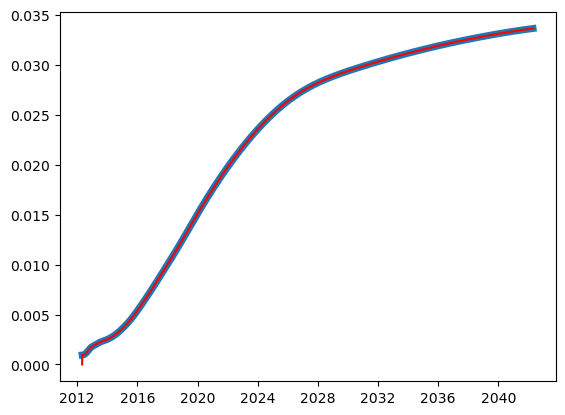

In [27]:
def plot_yc(date, curve: ql.ZeroCurve = None): 
    date_mask = date
    zero_rates = yield_curve.loc[date_mask]
    
    fig, ax = plt.subplots()
    
    dates, rates = zip(*curve.nodes())
    dates = [d.to_date() for d in dates]
    
    print(dates[:3])
    print(rates[:3])
    
    ax.plot(dates[1:], zero_rates, lw='5')
    ax.plot(dates, rates, c='red')
    
plot_yc('2012-04-30', spot_crv)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=809bdc60-6cc4-4659-aae8-7be15b203bd4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>